In [107]:
%load_ext autoreload
%autoreload 2
%cd ..

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home


In [158]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import itertools
from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
%matplotlib inline

In [109]:
env = CliffWalkingEnv()

# Environment

In [110]:
print(env.reset())
env.render()

print(env.step(1))
env.render()

print(env.step(0))
env.render()

36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

(37, -100.0, True, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  C  C  C  C  C  C  C  C  C  T

(25, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



# SARSA

In [111]:
n_episodes = 200

In [112]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [113]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate episode
        state = env.reset()
        for step in itertools.count():
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = step

            # TD update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error

            if done:
                break
            state = next_state
            action = next_action
        
    
    return Q, stats



In [114]:
Q, stats_s = sarsa(env, n_episodes)



Episode 200/200.

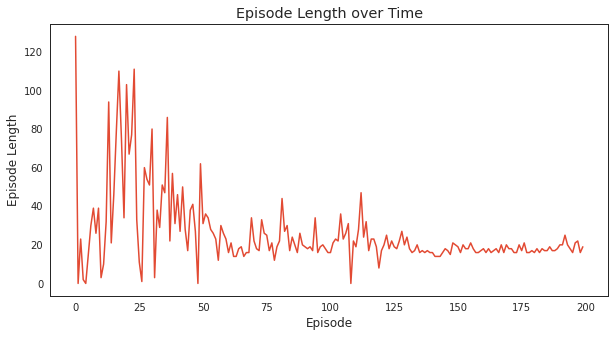

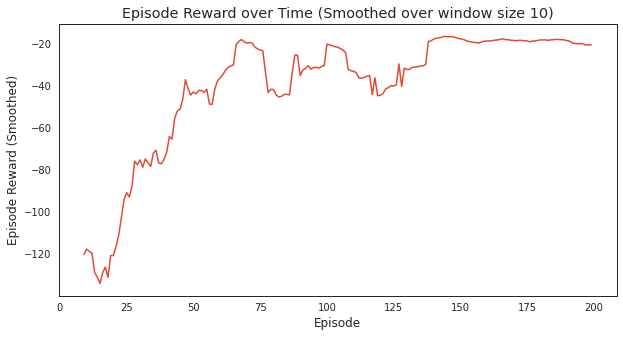

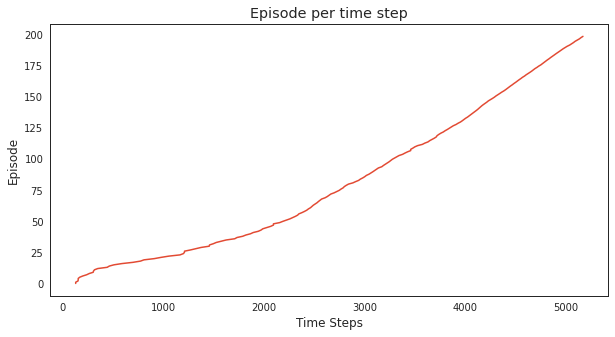

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [115]:
plotting.plot_episode_stats(stats_s)

# Q-Learning

In [116]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate episode
        state = env.reset()
        for step in itertools.count():
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = step

            # TD update
            """
            The difference with SARSA is that Q-Learning updates its Q-values using the greedy action best_next_action. In other words, it estimates the return (total discounted future reward) for state-action pairs assuming a greedy policy were followed despite the fact that it's not following a greedy policy. Hence it's off-policy while SARSA is on-policy.
            """
            best_next_action = np.argmax(Q[next_state]) 
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error

            if done:
                break
            state = next_state
    
    return Q, stats

In [117]:
Q, stats_q = q_learning(env, n_episodes)

Episode 200/200.

# Expected SARSA

In [118]:
def expected_sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Expected SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy. 
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate episode
        state = env.reset()
        for step in itertools.count():
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = step

            # TD update
            expected_action_value = sum(next_action_probs*Q[next_state])
            td_target = reward + discount_factor * expected_action_value
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error

            if done:
                break
            state = next_state
            action = next_action
        
    
    return Q, stats



In [119]:
Q, stats_es = expected_sarsa(env, n_episodes)

Episode 200/200.

# Double Q Learning
Double learning can be implemented also with SARSA and Expected SARSA

In [120]:
def make_epsilon_greedy_policy2(Q1, Q2, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q1: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        Q2: Same as above
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        Q = Q1[observation]+Q2[observation]
        best_action = np.argmax(Q)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [121]:
def double_q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Double Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy while following an epsilon-greedy policy. Avoids maximization bias through double learning.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The double action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
    Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy2(Q1, Q2, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate episode
        state = env.reset()
        for step in itertools.count():
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = step

            # TD update: randomly update Q1 or Q2
            p = np.random.random()
            if p < 0.5:
                best_next_action = np.argmax(Q1[next_state]) 
                td_target = reward + discount_factor * Q2[next_state][best_next_action]
                td_error = td_target - Q1[state][action]
                Q1[state][action] = Q1[state][action] + alpha * td_error
            else:
                best_next_action = np.argmax(Q2[next_state]) 
                td_target = reward + discount_factor * Q1[next_state][best_next_action]
                td_error = td_target - Q2[state][action]
                Q2[state][action] = Q2[state][action] + alpha * td_error

            if done:
                break
            state = next_state
    
    return Q, stats

In [122]:
Q, stats_dq = double_q_learning(env, n_episodes)

Episode 200/200.

# Performance comparison

In [163]:
x = np.arange(n_episodes)

smooth = lambda x, y: np.poly1d(np.polyfit(x, y, 17))(x)
# Polynomial approximation produces some artifacts at the end and at the beginning

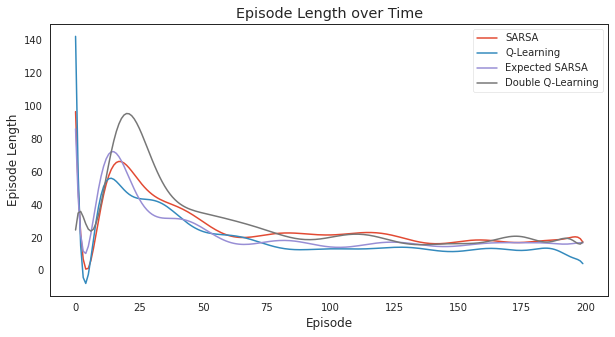

In [156]:
fig1 = plt.figure(figsize=(10,5))
plt.plot(smooth(x, stats_s.episode_lengths), label="SARSA")
plt.plot(smooth(x, stats_q.episode_lengths), label="Q-Learning")
plt.plot(smooth(x, stats_es.episode_lengths), label="Expected SARSA")
plt.plot(smooth(x, stats_dq.episode_lengths), label="Double Q-Learning")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("Episode Length over Time")
plt.legend(loc="upper right")
plt.show()


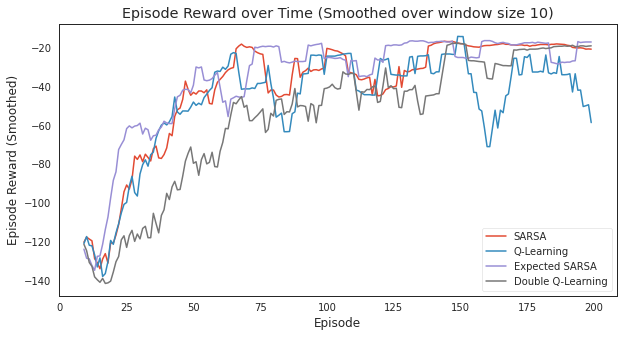

In [166]:
# Plot the episode reward over time
smoothing_window=10

fig2 = plt.figure(figsize=(10,5))
for stats, name in [(stats_s, "SARSA"), (stats_q, "Q-Learning"), (stats_es, "Expected SARSA"), (stats_dq, "Double Q-Learning")]:
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    #rewards_smoothed = smooth(x, stats.episode_rewards)
    plt.plot(rewards_smoothed, label=name)
plt.xlabel("Episode")
plt.ylabel("Episode Reward (Smoothed)")
plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
plt.legend(loc="lower right")
